In [1]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import calendar
import os
import psutil
import math

In [2]:
fileDrive = r'C:\Users\mikel\Desktop\Guosheng\Daily'
#fileDrive = 'D:\\HKUST\\GuoshenIntern\\Redo\\RawData\\'
startDay = 20130327
endDay = 20180105 + 1
offsetWindow = 60
tradingDateAll = loadmat(os.path.join(fileDrive,'TradingDate_Daily.mat'))['TradingDate_Daily'][:,0]    # one column, a row per day
startDayIndex = np.array(np.where(tradingDateAll>=startDay))[0][0]
endDayIndex = np.array(np.where(tradingDateAll>=endDay))[0][0]
tradingDate = tradingDateAll[startDayIndex : endDayIndex]

In [3]:
# trading days in the sample period
endDayIndex - startDayIndex

1166

In [4]:
allStockCode = pd.Series(loadmat(os.path.join(fileDrive,'AllStockCode.mat'))['AllStockCode'][0])
allStockCode = allStockCode.apply(lambda x : x[0]).values

In [ ]:
%%time
# lambda method  1.6minutes
zz500 = pd.read_excel(os.path.join(fileDrive,'指数成分股 300&500.xlsx'),sheet_name='中证500',header = 0)
isIndexDF = pd.DataFrame(data = None,index=tradingDate,columns=allStockCode, dtype=np.int8)
def isIndex(theDate):
    col_index = (theDate//10000 - 2007)*12 + theDate//100%100 - 1
    stockList = zz500.iloc[:,col_index].values
    temp = pd.Series(allStockCode,index=allStockCode)
    temp = temp.apply(lambda x : 1 if x in stockList else 0)
    return temp
isIndexDF = isIndexDF.apply(lambda x : isIndex(x.name), axis = 1)
isIndexDF.to_csv(os.path.join(fileDrive,'isIndexDF.csv'), header=True, index=True)

In [5]:
isIndexDF = pd.read_csv(os.path.join(fileDrive,'isIndexDF.csv'),header=0,index_col=0)

In [6]:
openPrice = loadmat(os.path.join(fileDrive,'AllStock_DailyOpen_dividend.mat'))['AllStock_DailyOpen_dividend'][startDayIndex:endDayIndex]
openPriceDF = pd.DataFrame(openPrice,index=tradingDate,columns=allStockCode)
closePrice = loadmat(os.path.join(fileDrive,'AllStock_DailyClose_dividend.mat'))['AllStock_DailyClose_dividend'][startDayIndex:endDayIndex]
closePriceDF = pd.DataFrame(closePrice,index=tradingDate,columns=allStockCode)
lowPrice = loadmat(os.path.join(fileDrive,'AllStock_DailyLow_dividend.mat'))['AllStock_DailyLow_dividend'][startDayIndex:endDayIndex]
lowPriceDF = pd.DataFrame(lowPrice,index=tradingDate,columns=allStockCode)
dailyListedDate = loadmat(os.path.join(fileDrive,'AllStock_DailyListedDate.mat'))['AllStock_DailyListedDate'][startDayIndex:endDayIndex]
dailyListedDateDF = pd.DataFrame(dailyListedDate,index=tradingDate,columns=allStockCode)
dailyST = loadmat(os.path.join(fileDrive,'AllStock_DailyST.mat'))['AllStock_DailyST'][startDayIndex:endDayIndex]
dailySTDF = pd.DataFrame(dailyST,index=tradingDate,columns=allStockCode)
dailyStatus = loadmat(os.path.join(fileDrive,'AllStock_DailyStatus.mat'))['AllStock_DailyStatus_use'][startDayIndex:endDayIndex]
dailyStatusDF = pd.DataFrame(dailyStatus,index=tradingDate,columns=allStockCode)
dailyTR = loadmat(os.path.join(fileDrive,'AllStock_DailyTR.mat'))['AllStock_DailyTR'][startDayIndex:endDayIndex]
dailyTRDF = pd.DataFrame(dailyTR,index=tradingDate,columns=allStockCode)

In [7]:
print(u'当前进程的内存使用：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024 / 1024) )
info = psutil.virtual_memory() 
print( u'电脑总内存：%.4f GB' % (info.total / 1024 / 1024 / 1024) ) 
print(u'当前使用的总内存占比：',info.percent) 

当前进程的内存使用：1.0305 GB
电脑总内存：15.8584 GB
当前使用的总内存占比： 48.5


In [8]:
isValidDF = isIndexDF[(dailyListedDateDF > 60) & (openPriceDF != closePriceDF.shift(1)) & (dailySTDF == 0) & (dailyStatusDF == 1) & (dailyStatusDF.shift(1) == 1)]

In [9]:
diKai = isValidDF[openPriceDF < closePriceDF.shift(1)].sum().sum() / isValidDF.sum().sum() 
diKaiGaoZhou = isValidDF[(openPriceDF < closePriceDF.shift(1)) & (closePriceDF > openPriceDF)].sum().sum() / isValidDF[openPriceDF < closePriceDF.shift(1)].sum().sum()
gaoKaiGaoZhou = isValidDF[(openPriceDF > closePriceDF.shift(1)) & (closePriceDF > openPriceDF)].sum().sum() / isValidDF[openPriceDF > closePriceDF.shift(1)].sum().sum()
diKai
diKaiGaoZhou
gaoKaiGaoZhou

0.5079778412550682

In [10]:
# 重新定义isValid, 只选低开样本
isValidDF = isIndexDF[(dailyListedDateDF > 60) & (openPriceDF < closePriceDF.shift(1)) & (openPriceDF/closePriceDF.shift(1) - 1 > -0.098) & (dailySTDF == 0) & (dailyStatusDF == 1) & (dailyStatusDF.shift(1) == 1) ]

In [11]:
dailyReturnDF = pd.DataFrame(None, index=tradingDate,columns=allStockCode)
dailyReturnDF[isValidDF == 1] =  closePriceDF / openPriceDF - 1
dailyReturnDF[(isValidDF == 1) & (lowPriceDF/closePriceDF.shift(1) - 1 < -0.098)] = lowPriceDF / openPrice - 1

In [12]:
diKaiFuDuDF = pd.DataFrame(data = None,index=tradingDate,columns=allStockCode)
diKaiFuDuDF[isValidDF == 1] = 1 - openPriceDF / closePriceDF.shift(periods=1, axis=0) 
# diKaiRankDF = pd.DataFrame(data = None,index=tradingDate,columns=allStockCode)   # maybe this line can be removed

In [ ]:
def diKaiBand(theDate):
    return (diKaiFuDuDF.loc[theDate].rank()/diKaiFuDuDF.loc[theDate].count()*10).apply(lambda x: math.ceil(x) if x>0 else np.nan)
diKaiBandDF = diKaiFuDuDF.apply(lambda x : diKaiBand(x.name), axis = 1)
diKaiBandDF.to_csv(os.path.join(fileDrive,'diKaiBandDF.csv'), header=True, index=True)

In [13]:
diKaiBandDF = pd.read_csv(os.path.join(fileDrive,'diKaiBandDF.csv'), header=0, index_col=0)

In [14]:
diKaiBandReturn = np.zeros(10)
diKaiBandCount = np.zeros(10)
for i in range(10):
    diKaiBandReturn[i] = dailyReturnDF[diKaiBandDF==i+1].mean(axis=1).mean()
    # diKaiBandCount[i] = dailyReturnDF[diKaiRankDF==i+1].apply(lambda x : 1 if x == i else 0).sum().sum()
    diKaiBandCount[i] = (diKaiBandDF == i + 1).sum().sum()

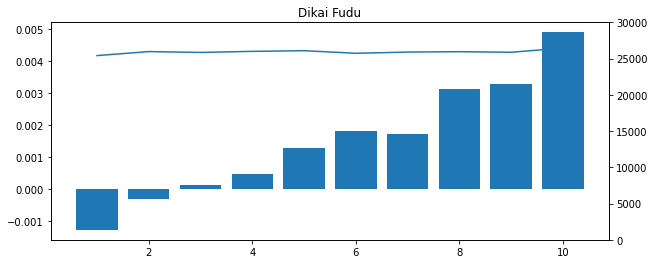

In [15]:
fig = plt.figure(figsize = [10,4])
ax1 = fig.add_subplot(111)
ax1.set_title('Dikai Fudu')
ax1.bar(range(1,len(diKaiBandReturn)+1), diKaiBandReturn)
ax2 = ax1.twinx()
ax2.plot(range(1,len(diKaiBandReturn)+1), diKaiBandCount)
ax2.set_yticks([i*5000 for i in range(7)])
plt.show()

In [29]:
%%time
# a time-consuming task, taking 20 minutes
def turnoverQ(x):
    rank =  ((x.rank()).values)[-1]
    return rank / x.count() 

turnoverQDF = dailyTRDF.shift(1).rolling(60).apply(turnoverQ,raw = False)
turnoverQDF = turnoverQDF[isValidDF==1]

CPU times: total: 13min 29s
Wall time: 13min 34s


In [30]:
def turnoverBand(theDate):
    return (turnoverQDF.loc[theDate].rank()/turnoverQDF.loc[theDate].count()*6).apply(lambda x: math.ceil(x) if x>0 else np.nan)

turnoverBandDF = turnoverQDF.apply(lambda x : turnoverBand(x.name), axis = 1)

turnoverQDF.to_csv(os.path.join(fileDrive,'turnoverQDF.csv'), header=True, index=True)
turnoverBandDF.to_csv(os.path.join(fileDrive,'turnoverBandDF.csv'), header=True, index=True)

In [31]:
turnoverQDF = pd.read_csv(os.path.join(fileDrive,'turnoverQDF.csv'), header=0, index_col=0)
turnoverBandDF = pd.read_csv(os.path.join(fileDrive,'turnoverBandDF.csv'), header=0, index_col=0)

In [34]:
turnoverBandReturn = np.zeros(6)
turnoverBandCount = np.zeros(6)
for i in range(6):
    turnoverBandReturn[i] = dailyReturnDF[turnoverBandDF==i+1].mean(axis=1).mean()
    turnoverBandCount[i] = (turnoverBandDF == i + 1).sum().sum()

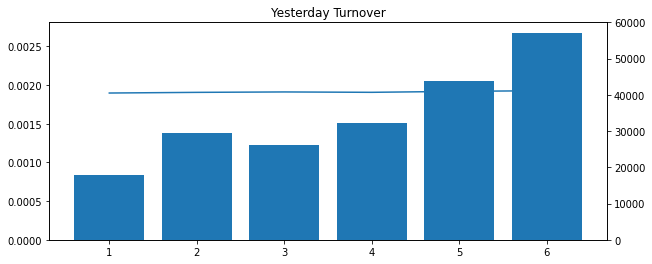

In [35]:
fig = plt.figure(figsize = [10,4])
ax1 = fig.add_subplot(111)
ax1.set_title('Yesterday Turnover')
ax1.bar(range(1,len(turnoverBandReturn)+1), turnoverBandReturn)
ax2 = ax1.twinx()
ax2.plot(range(1,len(turnoverBandCount)+1), turnoverBandCount)
ax2.set_yticks([i*10000 for i in range(7)])
plt.show()

In [19]:
# 辅助函数，用于计算值X在数组V中的排序位置
def percentile_rank(x,v):
    return (v <= x).sum() / len(v)

In [20]:
openningQuanPercentileDF = pd.DataFrame(None,index=tradingDate,columns=allStockCode)
openningQuanBandDF = pd.DataFrame(None,index=tradingDate,columns=allStockCode)

In [21]:
minuteDataF = loadmat(r'C:\Users\mikel\Desktop\data\UnAdjstedStockMinute_' + allStockCode[50][0:6] + '.mat')

In [ ]:
%%time
#taking 13 minutes
#minutesDataColumns = ['交易日','分开盘','分高价','分低价','分收盘','成交量','成交额']
missingFileCodes = []
for stockCode in allStockCode:
    try: 
        minuteDataF = loadmat(r'C:\Users\mikel\Desktop\data\UnAdjstedStockMinute_' + stockCode[0:6] + '.mat')
    except Exception as e:
        missingFileCodes.append(stockCode)
        continue
    minuteData = minuteDataF['UnAdjstedStockMinute_'+stockCode[0:6]]
    for i in range(offsetWindow, min(int(minuteData.size/7/242),tradingDate.size)):     #从 offsetWindow = 60（2013.7.1)开始统计，前60天从2013.3.27开始. 分钟数据从2013.3.26开始
        if isValidDF[stockCode].iloc[i] == 1:
            openningQuanList = []
            for k in range(offsetWindow):
                #这里应该是4不是5
                openningQuanList.append(minuteData[(i-offsetWindow+k)*242][4])    # 数据第一天是2013.3.26，每天242行数据
            openningQuanArray = np.array(openningQuanList)
            #这里也是4不是5
            openningQuanPercentileDF.loc[tradingDate[i],stockCode] = percentile_rank(minuteData[i*242][4],openningQuanArray)
#openningQuanPercentileDF = openningQuanPercentileDF[isValidDF==1]
openningQuanPercentileDF.to_csv(os.path.join(fileDrive,'openningQuanPercentileDF.csv'), header=True, index=True)

In [22]:
openningQuanPercentileDF = pd.read_csv(os.path.join(fileDrive,'openningQuanPercentileDF.csv'),header=0,index_col=0)

def openningQuanBand(theDate):
    return (openningQuanPercentileDF.loc[theDate].rank()/openningQuanPercentileDF.loc[theDate].count()*10).apply(lambda x: math.ceil(x) if x>0 else np.nan)
openningQuanBandDF = openningQuanPercentileDF.apply(lambda x : openningQuanBand(x.name), axis = 1)

openningQuanBandDF.to_csv(os.path.join(fileDrive,'openningQuanBandDF.csv'), header=True, index=True)

In [24]:
openningQuanBandDF = pd.read_csv(os.path.join(fileDrive,'openningQuanBandDF.csv'),header=0,index_col=0)

In [25]:
openningQuanBandReturn = np.zeros(10)
openningQuanBandCount = np.zeros(10)
for i in range(10):
    openningQuanBandReturn[i] = dailyReturnDF[openningQuanBandDF==i+1].mean(axis=1).mean()
    # diKaiBandCount[i] = dailyReturnDF[diKaiRankDF==i+1].apply(lambda x : 1 if x == i else 0).sum().sum()
    openningQuanBandCount[i] = (openningQuanBandDF == i + 1).sum().sum()
size = (openningQuanBandDF > 0).sum().sum()

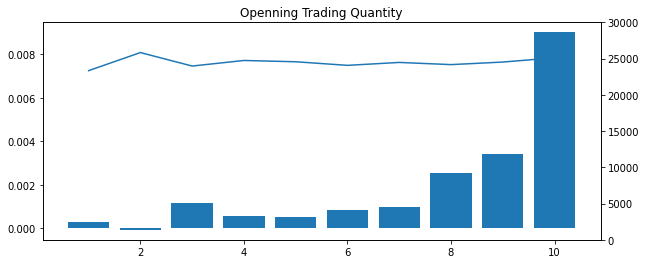

In [26]:
fig = plt.figure(figsize = [10,4])
ax1 = fig.add_subplot(111)
ax1.set_title('Openning Trading Quantity')
ax1.bar(range(1,len(openningQuanBandReturn)+1), openningQuanBandReturn)
ax2 = ax1.twinx()
ax2.plot(range(1,len(openningQuanBandCount)+1), openningQuanBandCount)
ax2.set_yticks([i*5000 for i in range(7)])
plt.show()

In [69]:
isSelected = pd.DataFrame(data = None,index = tradingDate,columns = allStockCode, dtype = np.int8)
isSelected[(diKaiBandDF == 10) & (turnoverBandDF > 3.0) & (openningQuanBandDF == 10.0)] = 1
#isSelected = diKaiBandDF[(diKaiBandDF == 10)]
(isSelected == 1).sum().sum()

4258

In [71]:
strategyReturn = dailyReturnDF[isSelected == 1].mean(axis=1).mean()
averageReturn = dailyReturnDF[isValidDF == 1].mean(axis=1).mean()
averageReturn

0.0015910225762841492

In [72]:
strategyReturn

0.01019163401446477

In [73]:
winCount = (dailyReturnDF[isSelected == 1] > 0).sum().sum()

In [75]:
winCount/(isSelected == 1).sum().sum()

0.5904180366369187